# Inference

## This notebook can be used to infere the motion prediction LSTM based on Rasterization


Created in July 2021;
Author: Armin Straller;
Email: armin.straller@hs-augsburg.de


## 1. Import libraries

In [43]:
import os
from os import walk
import numpy as np
import imageio
import scipy.signal
import cv2 as cv
from IPython.display import Image, display
from skimage.transform import rescale
import time

import tensorflow as tf
tf.config.optimizer.set_experimental_options({'layout_optimizer': False})
from tensorflow.keras import datasets, layers, models

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import sys
sys.path.append('/home/dev/motion-prediction-cnn/motion-prediction')
from convert_single_scenario import tf_example_scenario

## 2. Set global dependencies

First define the location of the scenarios to use for inference. Additionally, define the path to the stored training checkpoint.

In [44]:
PATHNAME = '/media/dev/data/waymo_motion/validation'
checkpoint_path = '/home/dev/motion-prediction-cnn/motion-prediction/training_checkpoints/static-map-100-epochs-1e-1s-custom-loss-kernel-531/cp-0100.ckpt'

Define the size of the rasterization grid and the length of the supplied data

In [45]:
GRID_SIZE = 128
DATA_LENGTH = 90

## 3. Init GPU

In [46]:
tf.keras.backend.clear_session()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

## 4. Utility functions

Loads a scenario defined in the location defined by ***PATHNAME*** and ***scenario_name***. ***last_int(x)*** is used to read in the files in the correct order.

In [47]:
def last_int(x):
    y = x.split("00150_")
    z = y[1].split(".")
    return(int(z[0]))

def load_scenario(n_frames=10):
    """
    load scenarios that were saved using convert_training_data.py
    """
    frames = np.zeros((1, n_frames, GRID_SIZE, GRID_SIZE, 1), dtype=np.float32)

    _, _, filenames = next(walk(PATHNAME + '/static_' + scenario_name))
    temp_frames = np.zeros((DATA_LENGTH, GRID_SIZE, GRID_SIZE, 1), dtype=np.float32)
    
    for filename in sorted(filenames, key = last_int)  :
        image = imageio.imread(PATHNAME + '/static_' + scenario_name + '/' + filename, as_gray=True)
        image = np.reshape(image, (GRID_SIZE,GRID_SIZE,1))
        filename_sections = filename.split('_')
        filename_index, _ = filename_sections[-1].split('.')
        temp_frames[int(filename_index)] = image/255
    
    frames[0] = temp_frames[0:n_frames]

    return frames

Function for postprocessing of the predicted frame. 
Every pixel brighter then a certain threshold is considered to be an object.

In [48]:
def postprocess_objects(frame):
    reduced_max = tf.reduce_max(frame)
    reduced_mean = tf.reduce_mean(frame)
    threshold_objects = reduced_max * 0.6
    mask_objects = tf.math.greater(frame, threshold_objects)
    mask_objects = tf.cast(mask_objects, dtype=tf.float32)
    return mask_objects * reduced_max

The ***predict_future_frame(frames)*** function uses the prediction interface of the model. The original map is retreived from the scenario definition and the predicted obejects are added to it. This way a good quality of the images passed to the LSTM in the next prediction step can be guaranteed.

In [49]:
def predict_future_frame(frames, correction=False):
    pred_frames = seq.predict(frames)

    FILEPATH = PATHNAME + '/validation_tfexample.' + scenario_name

    scenario_converter = tf_example_scenario(128, 1)
    map = scenario_converter.load_map_at(FILEPATH, [0.0, 0.0,0.0], 0, 9)
    map = np.expand_dims(map, axis=2)/255

    objects = postprocess_objects(pred_frames[0, 9]).numpy()

    # use the section below to mask out objetcs from the map
    threshold = tf.reduce_max(objects)
    mask_objects = tf.math.less(objects, threshold)
    mask_objects = tf.cast(mask_objects, dtype=tf.float32)
    map_masked = mask_objects * map

    prediction = np.add(map_masked, objects)
    if correction == False:
        # CONTROL: uncommenting the line below disables the prediction data improvement
        prediction = pred_frames[0, 9]
    return prediction

## 5. Create the model

Create a basic model instance. The model is consits of multiple Convolutional LSTM 2D Layers.

In [50]:
seq = tf.keras.Sequential(
    [
        tf.keras.Input(
            shape=(10, GRID_SIZE, GRID_SIZE, 1), dtype="float32"
        ),
        layers.ConvLSTM2D(
            filters=128, kernel_size=(5, 5), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=128, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=128, kernel_size=(1, 1), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.Conv3D(
            filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
        ),
    ]
)

The custom loss function is used for compilation 

In [51]:
def only_bright_pixels_custom(y_true, y_pred):
    
    threshold = tf.reduce_max(y_true) / 2
    mask_vehicle = tf.math.greater(y_true, threshold)
    mask_map = tf.math.less(y_true, threshold)


    mask_vehicle = tf.cast(mask_vehicle, dtype=tf.float32)
    mask_map = tf.cast(mask_map, dtype=tf.float32)
    y_true_masked_vehicle = mask_vehicle * y_true
    y_pred_masked_vehicle =  mask_vehicle * y_pred

    # set the true value to zero. this way all other pixels then the vehicles will go black
    y_true_masked_map = mask_map * 0.0
    y_pred_masked_map =  mask_map * y_pred

    squared_difference_vehicle = tf.square(y_true_masked_vehicle - y_pred_masked_vehicle)
    squared_difference_map = tf.square(y_true_masked_map - y_pred_masked_map)

    return tf.reduce_mean(squared_difference_vehicle, axis=1) * 0.5 + tf.reduce_mean(squared_difference_map, axis=1) * 0.5

Compiling the model.

In [52]:
seq.compile(loss=only_bright_pixels_custom, optimizer="adadelta", metrics=['mse'])

### Now load the model weihts from the previously defined training checkpoint

In [62]:
# checkpoint_dir = os.path.dirname(checkpoint_path)
# latest = tf.train.latest_checkpoint(checkpoint_dir)
seq.load_weights(checkpoint_path)
seq.summary()

print(tf.keras.backend.floatx())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 10, 128, 128, 128) 1651712   
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 128, 128, 128) 512       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 128, 128, 128) 1180160   
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 128, 128, 128) 512       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 10, 128, 128, 128) 131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 128, 128, 128) 512       
_________________________________________________________________
conv3d (Conv3D)              (None, 10, 128, 128, 1)   3

## 6. Select Scenario for prediction

### **- Vehicles going in opposite directions**
Vehicles driving in opposite directions. This leads to prediction errors.

In [54]:
scenario_name = 'tfrecord-00012-of-00150'

### **- Braking for Traffic Light**
Predictions of future positions show trends for taking a differnt lane. Also fast objects at end of line have larger predicted areas then small ones.  

In [55]:
scenario_name = 'tfrecord-00043-of-00150'

### **- Many objects and rotated map**
Intersection with small rotation. This leads to bad rasterization results.

In [56]:
scenario_name = 'tfrecord-00020-of-00150'

### - **Vehicles driving towards static object**
A static object is parked on the right lane. Vehicles slow down for it.

In [57]:
scenario_name = 'tfrecord-00050-of-00150'

### - **Few objects**
Three objects drive straight.

In [58]:
scenario_name = 'tfrecord-00038-of-00150'

## 7. Performing prediction

Prediction: 10/10

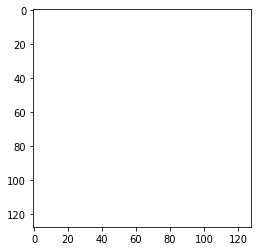

In [64]:
predicted_frames = np.zeros((30, 128, 128, 1))
input_frames = load_scenario()
updated_input = input_frames
# Predict 10 Frames
for j in range(10):
    # predict single frame and add it to the predicted_frames
    predicted_frames[j] = predict_future_frame(updated_input[np.newaxis, 0], correction=False)
    updated_input = np.delete(updated_input, 0, 1)
    predicted_frame = np.array([predicted_frames[j]])
    updated = np.concatenate((updated_input[0], predicted_frame), axis=0)
    updated_input = np.zeros((1, 10, 128, 128, 1))
    updated_input[0] = updated
    
    sys.stdout.write("\rPrediction: " + str(j+1) + "/10")
    sys.stdout.flush()

# https://stackoverflow.com/questions/25333732/matplotlib-animation-not-working-in-ipython-notebook-blank-plot
plt.rcParams["animation.html"] = "jshtml"
fig = plt.figure()

ims = []
for i in range(1, 20):
    if i < 10:
        im = plt.imshow(input_frames[0][i], animated=True)
        ims.append([im])
    if i >= 10:
        im = plt.imshow(updated_input[0][i-10], animated=True)
        ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
ani

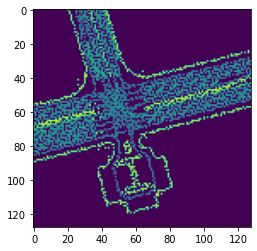

In [60]:
scenario_name = 'tfrecord-00002-of-00150'
FILEPATH = PATHNAME + '/validation_tfexample.' + scenario_name

scenario_converter = tf_example_scenario(128, 1)
map = scenario_converter.load_map_at(FILEPATH, [0.0, 0.0,0.0], 0, 50)
map = np.expand_dims(map, axis=2)/255
plt.imshow(map)
plt.show()

Prediction: 10/10

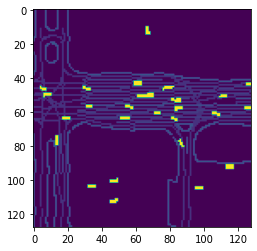

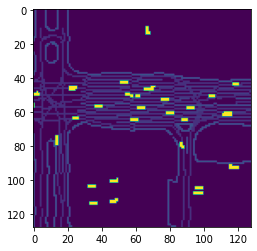

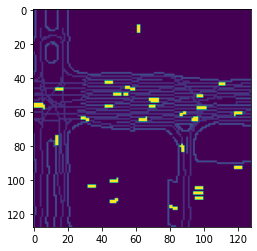

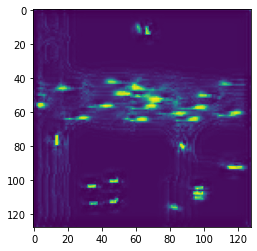

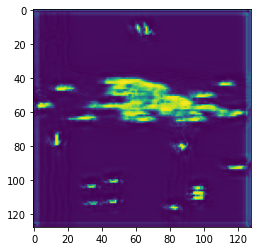

In [67]:
scenario_name = 'tfrecord-00050-of-00150'

predicted_frames = np.zeros((30, 128, 128, 1))
input_frames = load_scenario()
updated_input = input_frames
# Predict 10 Frames
for j in range(10):
    # predict single frame and add it to the predicted_frames
    predicted_frames[j] = predict_future_frame(updated_input[np.newaxis, 0], correction=False)
    updated_input = np.delete(updated_input, 0, 1)
    predicted_frame = np.array([predicted_frames[j]])
    updated = np.concatenate((updated_input[0], predicted_frame), axis=0)
    updated_input = np.zeros((1, 10, 128, 128, 1))
    updated_input[0] = updated
    
    sys.stdout.write("\rPrediction: " + str(j+1) + "/10")
    sys.stdout.flush()

plt.imshow(input_frames[0][1])
plt.show()
plt.imshow(input_frames[0][5])
plt.show()
plt.imshow(input_frames[0][9])
plt.show()
plt.imshow(updated_input[0][1])
plt.show()
plt.imshow(updated_input[0][9])
plt.show()
